Author: Parth S. Shah

In [ ]:
# If using this on Google collab, we need to install the packages
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# If in Colab install qiskit
if IN_COLAB:
    !pip install qiskit

In [9]:
# Import the necessary packages
from qiskit import BasicAer, execute, QuantumCircuit
from qiskit.quantum_info import random_statevector, Statevector
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram, plot_bloch_multivector

# Here we use COBYLA from qiskit for optimisation
from qiskit.aqua.components.optimizers import COBYLA

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from itertools import combinations

# Need to use the statevector simulator since we need to find the norm of the
# difference of the 2 vectors
backend = BasicAer.get_backend("statevector_simulator")

# define some global parameters. N is the number of qubits and MAX_DEPTH is the 
# maximum number of layers as defined by the problem.
# Tolerance and maxiter are for the optimizer. If we are running for larger 
# depths, then we need to increase the maxiter parameter. We could also use a 
# different value for different depths.
N = 4
MAX_DEPTH = 10
tol = 1e-3
maxiter = 1500

params = []
complete_circuit = QuantumCircuit(N)
phi = np.asarray(random_statevector(2**N).data)
final_vector = 0

# Even block as defined in the problem
def even_block(theta):
    eb = QuantumCircuit(N)
    # Rz gates
    for i in range(N):
        eb.rz(theta[i], i)
    # CNOT gates. Full entanglement. Note that since the combinations function
    # has been used, the middle 2 gates' position are interchanged wrt. the 
    # problem, but it does not make a difference.
    for i in combinations(range(N), 2):
        eb.cx(i[0], i[1])
    return eb

# Odd block as defined in the problem
def odd_block(theta):
    ob = QuantumCircuit(N)
    # Rx gates
    for i in range(N):
        ob.rx(theta[i], i)
    return ob

# Cost function. Note that here we only return the square of the norm for faster
# calculations. Since minimising the square is the same as minimising the norm 
# it still works.
def evaluate_cost(angles):
    params_dict = {}
    # Create the dictionary to bind parameters
    for i, angle in enumerate(angles):
        params_dict[params[i]] = angle
    final_state = execute(complete_circuit.bind_parameters(params_dict), backend = backend).result().get_statevector()
    final_vector = final_state
    temp = np.abs((final_vector-phi))
    return temp.dot(temp)

optimizer = COBYLA(maxiter=maxiter, tol=tol)
costs = []

# Use the optimiser for each appending of a layer.
for L in range(1, MAX_DEPTH+1):
    odd_params = [Parameter("theta_"+str(2*L-1)+"_"+str(i)) for i in range(N)]
    params += odd_params
    even_params = [Parameter("theta_"+str(2*L)+"_"+str(i)) for i in range(N)]
    params += even_params
    complete_circuit.append(odd_block(odd_params), range(N))
    complete_circuit.barrier()
    complete_circuit.append(even_block(even_params), range(N))
    complete_circuit.barrier()
    # print(complete_circuit.decompose().draw())
    n = len(params)
    results = optimizer.optimize(n, objective_function=evaluate_cost, variable_bounds = [(0,2*np.pi) for i in range(n)], initial_point=np.random.random(n))
    # print("Phi = ", phi.data)
    print("\nNumber of layers = ", L, "\nMinimal cost = ",results[1], "\nNumber of iterations = ", results[2])#, "\nAngles = ", results[0])
    costs.append(results[1])

# angles = np.random.random(2*N)
# x = evaluate_cost(angles)
# print(np.sum())


Number of layers =  1 
Minimal cost =  0.6779039101467046 
Number of iterations =  1032

Number of layers =  2 
Minimal cost =  0.32114729601688713 
Number of iterations =  1500

Number of layers =  3 
Minimal cost =  0.1530354694261478 
Number of iterations =  1500

Number of layers =  4 
Minimal cost =  0.016597461178307692 
Number of iterations =  1500

Number of layers =  5 
Minimal cost =  0.010083444189883523 
Number of iterations =  1500

Number of layers =  6 
Minimal cost =  0.013036631971177368 
Number of iterations =  1500

Number of layers =  7 
Minimal cost =  0.0023064364061478543 
Number of iterations =  1500

Number of layers =  8 
Minimal cost =  0.0035862841346820207 
Number of iterations =  1500

Number of layers =  9 
Minimal cost =  0.001281439069901779 
Number of iterations =  1500

Number of layers =  10 
Minimal cost =  0.0007488225279245771 
Number of iterations =  1500


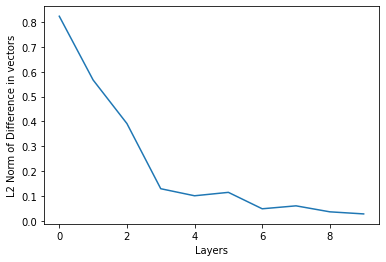

In [10]:
# Plot of costs against Layers
plt.xlabel("Layers")
plt.ylabel("L2 Norm of Difference in vectors")
plt.plot(np.sqrt(costs))

As can be seen the error begins to converge to 0. Note that more iterations must be used for higher layers to continue seeing thi pattern.